<a href="https://colab.research.google.com/github/rouopak/Titanic-Survival-Model/blob/main/Titanic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train data shape: (891, 12)
Test data shape: (418, 11)

Train data first few rows:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            1138

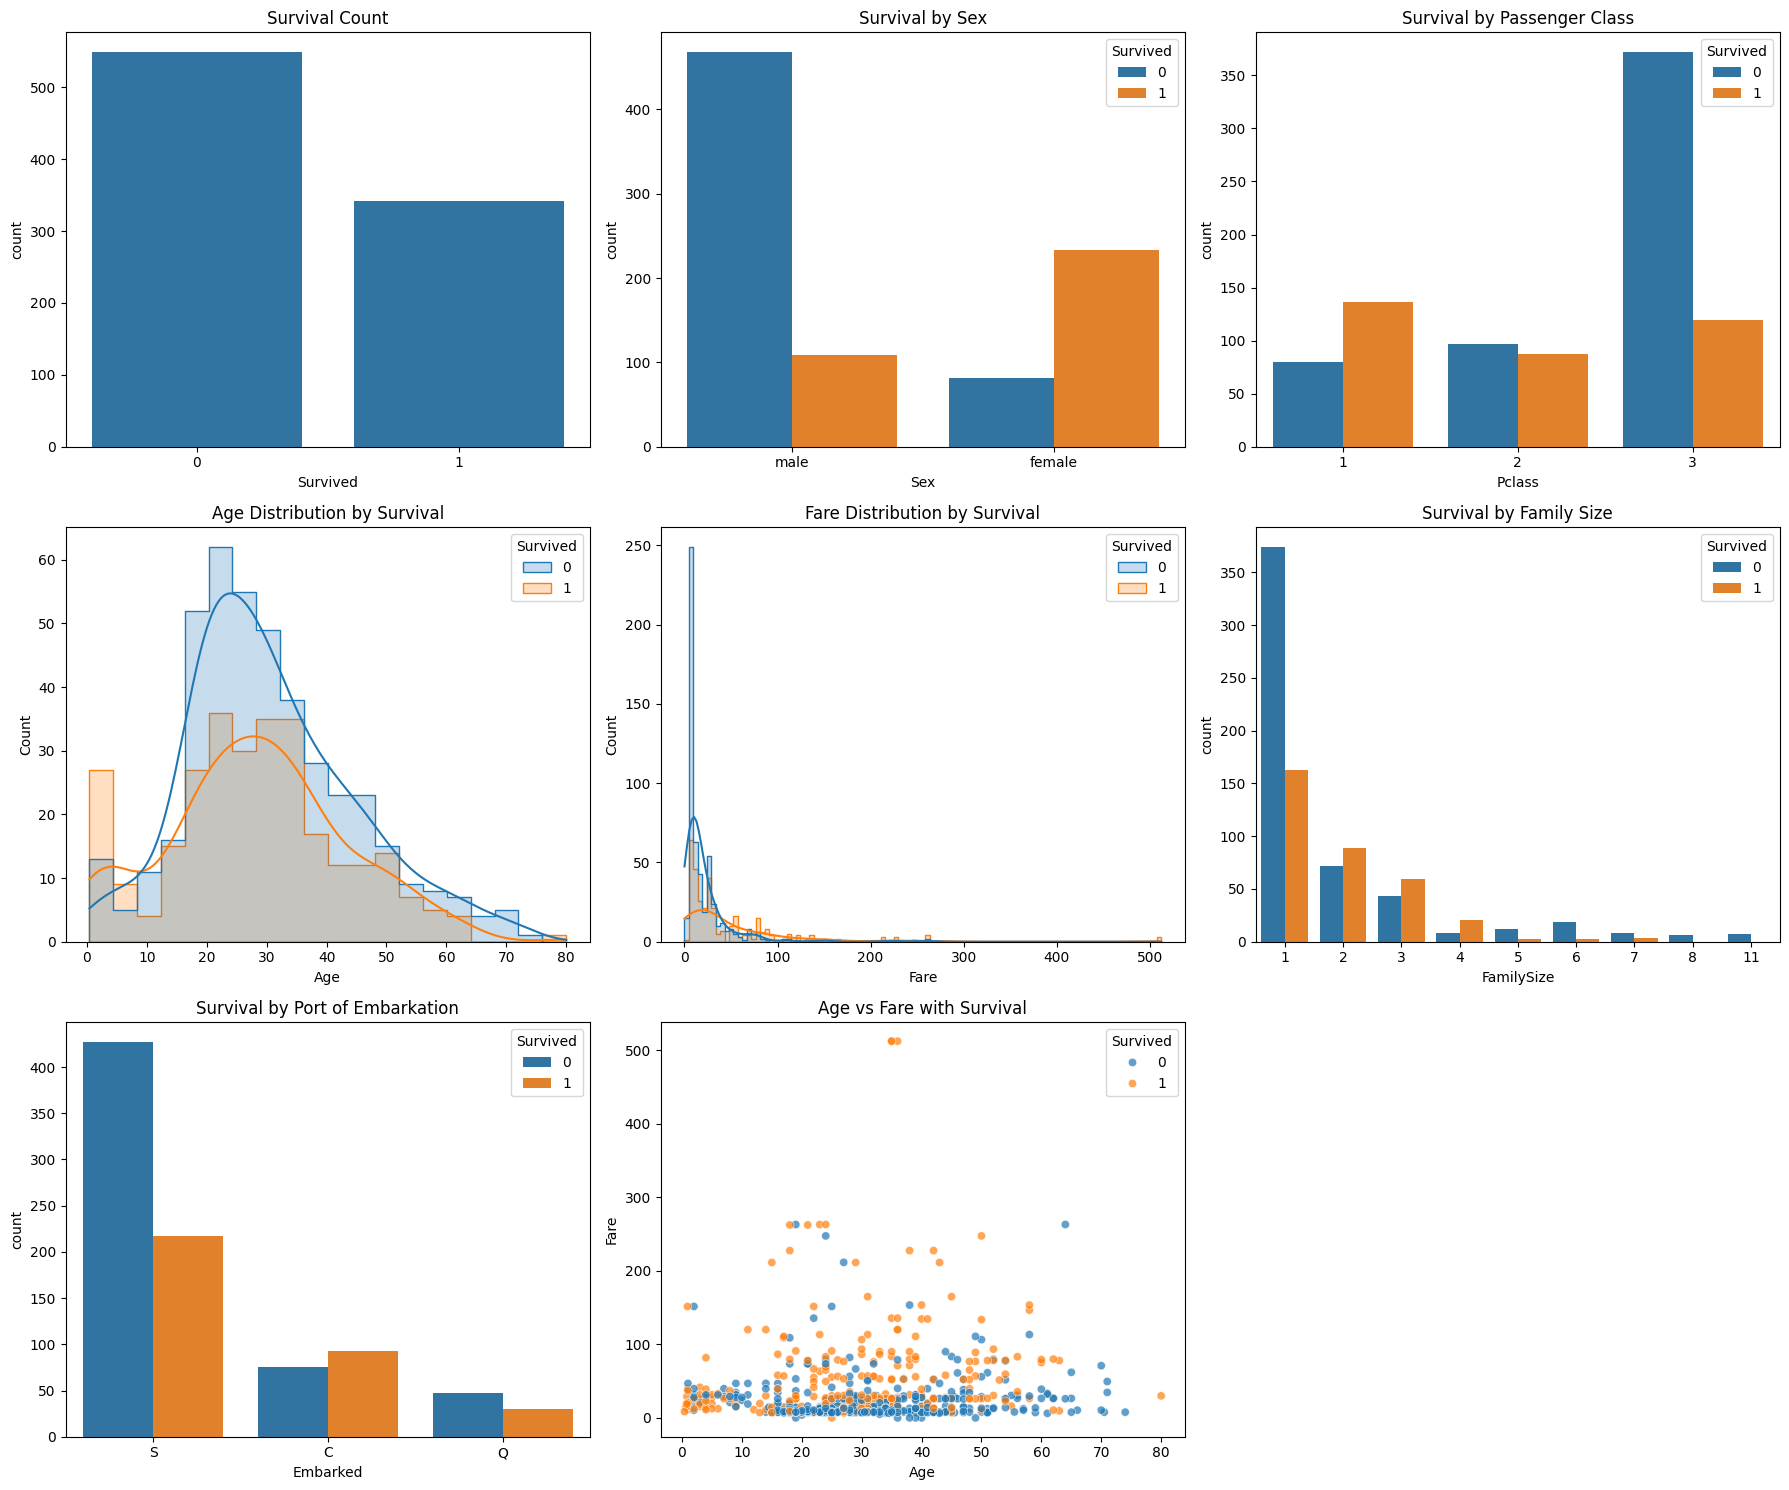


--- Missing Data Analysis for Training Data ---
          Missing Values  Percentage (%)
Cabin                687           77.10
Age                  177           19.87
Embarked               2            0.22

--- Missing Data Analysis for Test Data ---
       Missing Values  Percentage (%)
Cabin             327           78.23
Age                86           20.57
Fare                1            0.24

Combined mean age: 29.88
Rows before Embarked deletion: 891
Rows after Embarked deletion: 889
Rows before Fare deletion: 418
Rows after Fare deletion: 417

--- Prediction Results ---
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         1

--- Feature Importance ---
            Feature  Importance
5              Fare    0.267715
2               Age    0.265031
1       Sex_Numeric    0.255681
0            Pclass    0.092680
3             SibSp    0.047236
4             Parch    0.038139
6  E

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

training="https://raw.githubusercontent.com/rouopak/Titanic-Survival-Model/refs/heads/main/train.csv"
testing="https://raw.githubusercontent.com/rouopak/Titanic-Survival-Model/refs/heads/main/test.csv"

train_data= pd.read_csv(training)
test_data= pd.read_csv(testing)

#copy of data for safety
train = train_data.copy()
test = test_data.copy()

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("\nTrain data first few rows:\n",train.head())
print("\n",train.describe())

#visualization
plt.figure(figsize=(18,15))
# Survival count
plt.subplot(3,3,1)
sns.countplot(x='Survived', data=train)
plt.title('Survival Count')

# Survival by Sex
plt.subplot(3,3,2)
sns.countplot(x='Sex', hue='Survived', data=train)
plt.title('Survival by Sex')

# Survival by Pclass
plt.subplot(3,3,3)
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title('Survival by Passenger Class')

# Age distribution
plt.subplot(3,3,4)
sns.histplot(data=train, x='Age', hue='Survived', kde=True, element="step", common_norm=False)
plt.title('Age Distribution by Survival')

# Fare distribution
plt.subplot(3,3,5)
sns.histplot(data=train, x='Fare', hue='Survived', kde=True, element="step", common_norm=False)
plt.title('Fare Distribution by Survival')

# Family size distribution
plt.subplot(3,3,6)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
sns.countplot(x='FamilySize', hue='Survived', data=train)
plt.title('Survival by Family Size')

# Embarked survival rates
plt.subplot(3,3,7)
sns.countplot(x='Embarked', hue='Survived', data=train)
plt.title('Survival by Port of Embarkation')

# Age vs Fare with survival
plt.subplot(3,3,8)
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train, alpha=0.7)
plt.title('Age vs Fare with Survival')

plt.tight_layout()
plt.show()

print("\n--- Missing Data Analysis for Training Data ---")
train_missing_values = train_data.isnull().sum()
train_missing_percent = (train_missing_values / len(train_data) * 100).round(2)
train_missing_df = pd.DataFrame({
    'Missing Values': train_missing_values,
    'Percentage (%)': train_missing_percent
})
train_missing_df = train_missing_df[train_missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
print(train_missing_df)

print("\n--- Missing Data Analysis for Test Data ---")
test_missing_values = test_data.isnull().sum()
test_missing_percent = (test_missing_values / len(test_data) * 100).round(2)
test_missing_df = pd.DataFrame({
    'Missing Values': test_missing_values,
    'Percentage (%)': test_missing_percent
})
test_missing_df = test_missing_df[test_missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
print(test_missing_df)

# Combine age columns from both datasets to calculate the mean
combined_age = pd.concat([train['Age'], test['Age']])
combined_mean_age = combined_age.mean()
print(f"\nCombined mean age: {combined_mean_age:.2f}")

# Impute missing ages
train['Age'].fillna(combined_mean_age, inplace=True)
test['Age'].fillna(combined_mean_age, inplace=True)

#From the data we can see embark and fare missing value are less
# Deleting those rows
if train['Embarked'].isna().sum() > 0:
    print(f"Rows before Embarked deletion: {len(train)}")
    train = train.dropna(subset=['Embarked'])
    print(f"Rows after Embarked deletion: {len(train)}")
if test['Fare'].isna().sum() > 0:
    print(f"Rows before Fare deletion: {len(test)}")
    test = test.dropna(subset=['Fare'])
    print(f"Rows after Fare deletion: {len(test)}")

# Converting features to numerical
train['Sex_Numeric'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex_Numeric'] = test['Sex'].map({'male': 0, 'female': 1})
train['Embarked_Numeric'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test['Embarked_Numeric'] = test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Modified features list - removed 'Has_Cabin'
features = ['Pclass', 'Sex_Numeric', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Numeric']

# Training the model
X_train = train[features]
y_train = train['Survived']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
X_test = test[features]
predictions = model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions.astype(int)
})

print("\n--- Prediction Results ---")
print(submission.head())

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importance)